## Series of analyses of Seattle Bike and Weather data
inspired by and borrowed from old example from jakevdp: https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [139]:
hourly = pd.read_csv("cleanedCounterData\SeattleUnifiedBike.csv", index_col='TimestampRecord', parse_dates=True, usecols=['TimestampRecord','Name','TotalCount'])
hourly.columns = ['Name','TotalCount']

In [140]:
daily = hourly.resample('d').sum()
weekly = daily.resample('w').sum()

In [144]:
defaultfiguresize = (20,10)
weekly.head()

,TotalCount
TimestampRecord,
2012-10-07,14292
2012-10-14,16795
2012-10-21,15509
2012-10-28,13437
2012-11-04,12194


## Basic Summary Visualizations

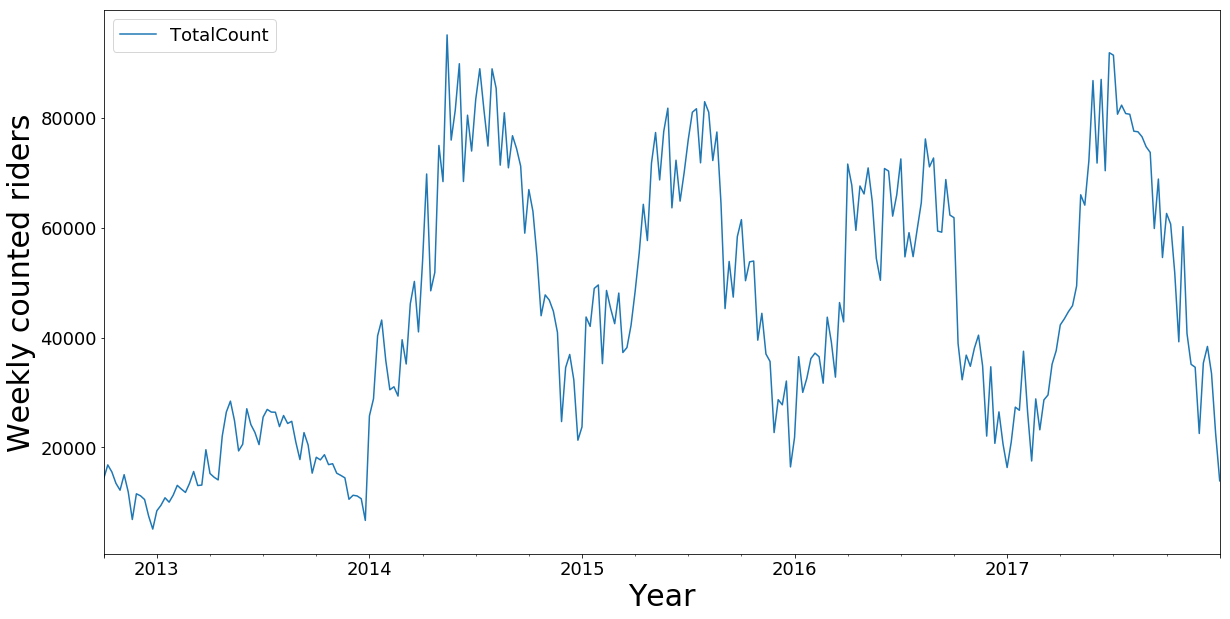

In [215]:
weekly[['TotalCount']].plot(figsize = defaultfiguresize,fontsize=18)
plt.xlabel('Year', size = 30)
plt.ylabel('Weekly counted riders', size = 30)
plt.legend(loc=2, prop={'size': 18});

Text(0.5,1,'30-day moving averages')

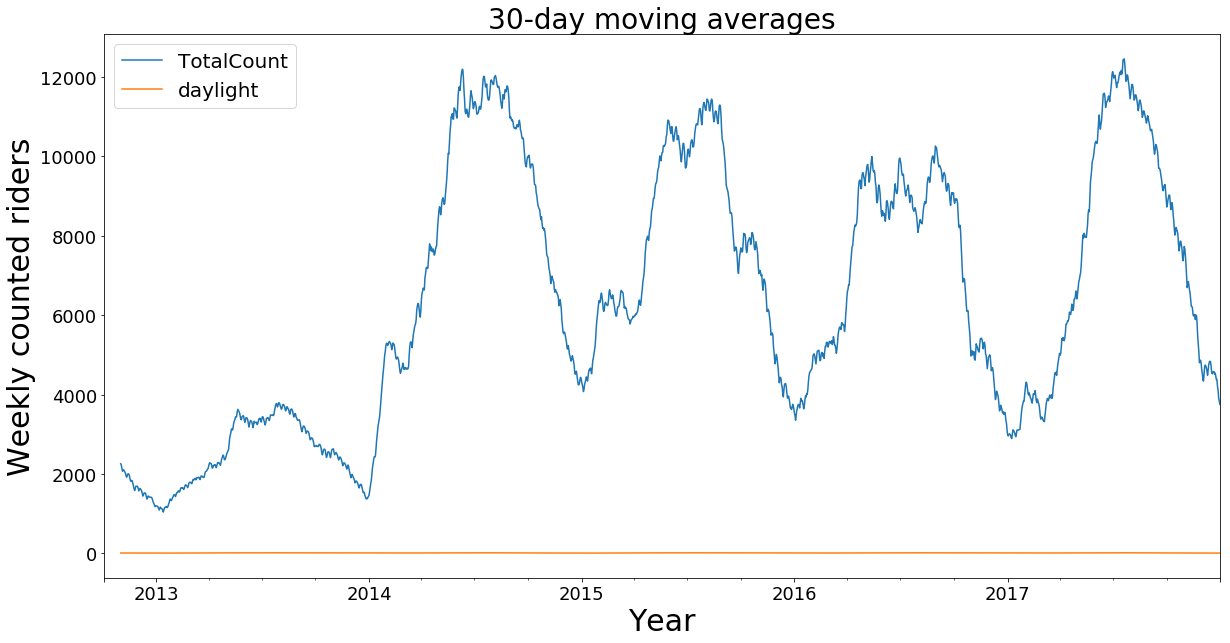

In [188]:
#smooth out with a rolling average
daily.rolling(window=30,center=False).mean().plot(figsize = defaultfiguresize,fontsize=18);
plt.xlabel('Year', size = 30)
plt.ylabel('Weekly counted riders', size = 30)
plt.legend(loc=2, prop={'size': 20});
plt.title('30-day moving averages', size = 28)

In [154]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365
import datetime

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    #m = max(0, min(m, 2)) #removing this min-max still gives approx results
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = hours_of_daylight(weekly.index)
daily['daylight'] = hours_of_daylight(daily.index)

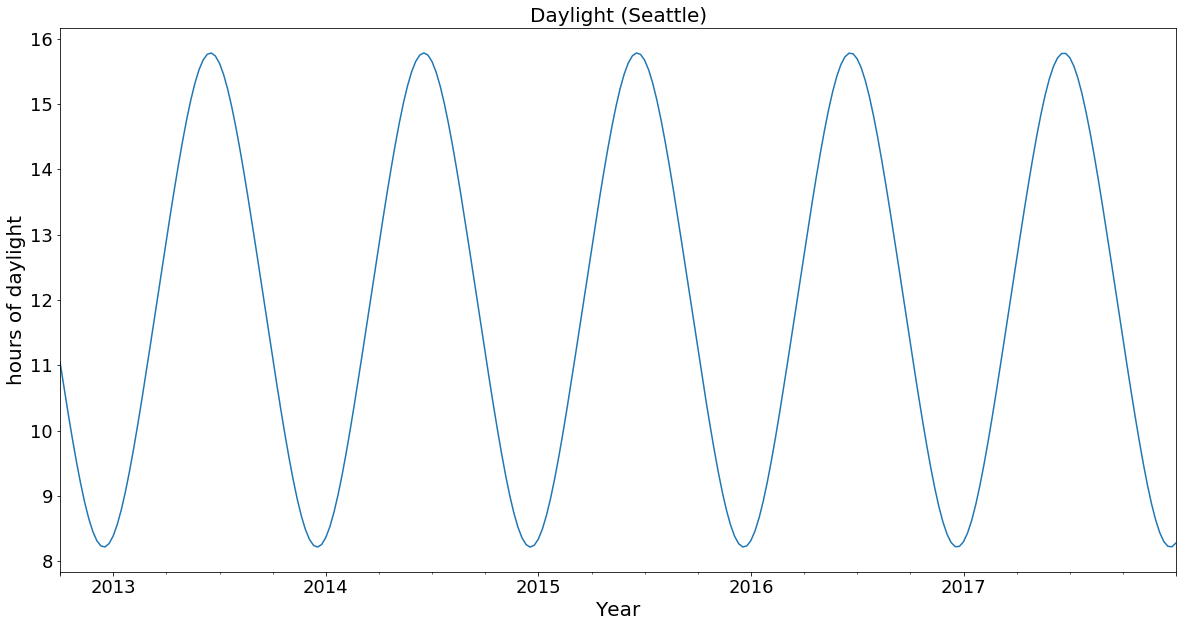

In [163]:
# Plot the daylight curve

weekly['daylight'].plot(figsize = defaultfiguresize,fontsize=18)
plt.ylabel('hours of daylight', size = 20);
plt.xlabel('Year', size = 20);
plt.title('Daylight (Seattle)', size = 20);

## Let's evaluate trending

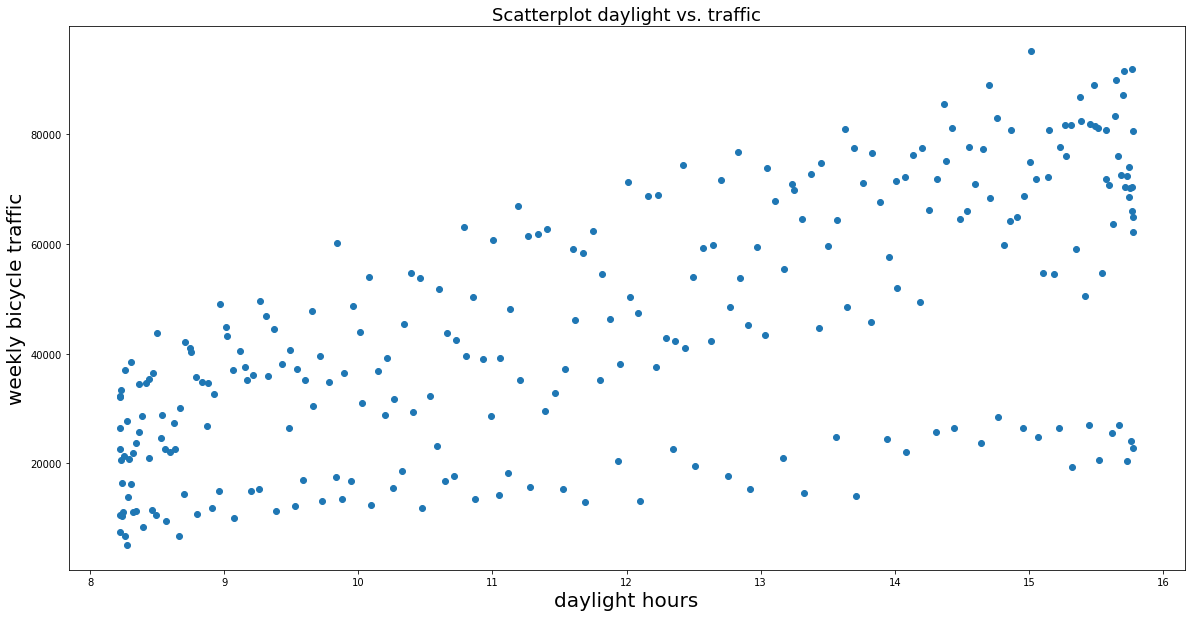

In [182]:
#see /some/ trending here
plt.figure(figsize = (defaultfiguresize))
plt.scatter(weekly['daylight'], weekly['TotalCount'])
plt.xlabel('daylight hours', size = 20)
plt.ylabel('weekly bicycle traffic', size = 20)
plt.title('Scatterplot daylight vs. traffic', size = 18);

## Let's put a number on relationship between sunlight and ridership

5887.68598149


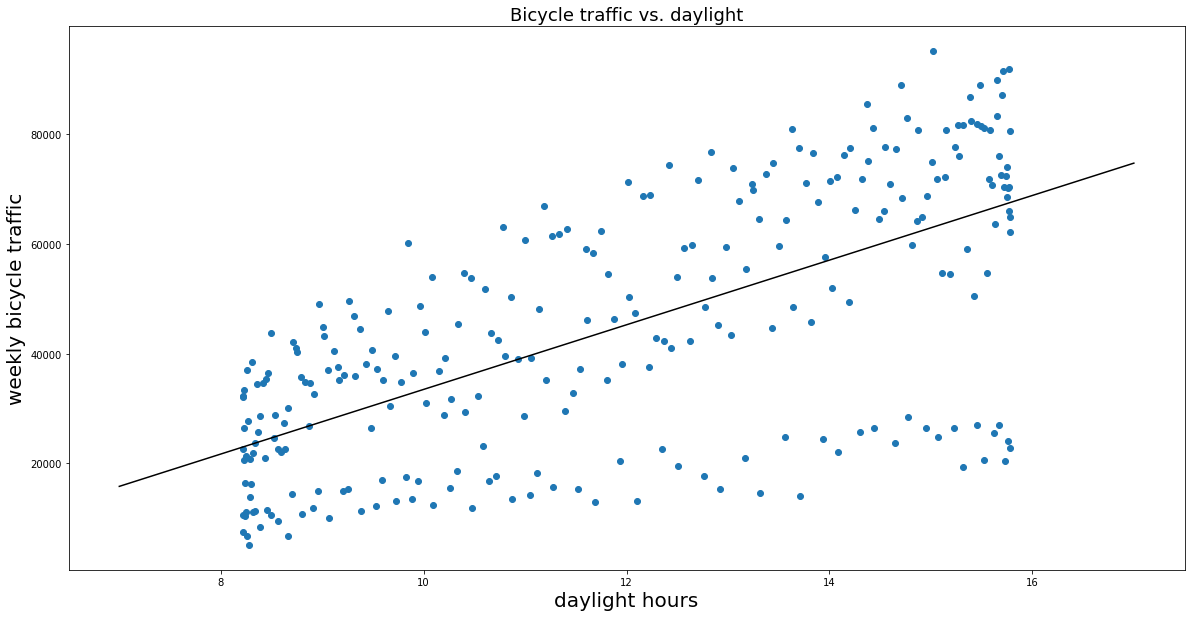

In [183]:
#nearly 6k per extra hour of sunlight!
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']].to_dense()
y = weekly['TotalCount']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['TotalCount'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.figure(figsize = (defaultfiguresize))
plt.scatter(weekly['daylight'], weekly['TotalCount'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic vs. daylight", size = 18)
plt.xlabel('daylight hours', size = 20)
plt.ylabel('weekly bicycle traffic', size = 20);
print(clf.coef_[0])

## De-trend the data

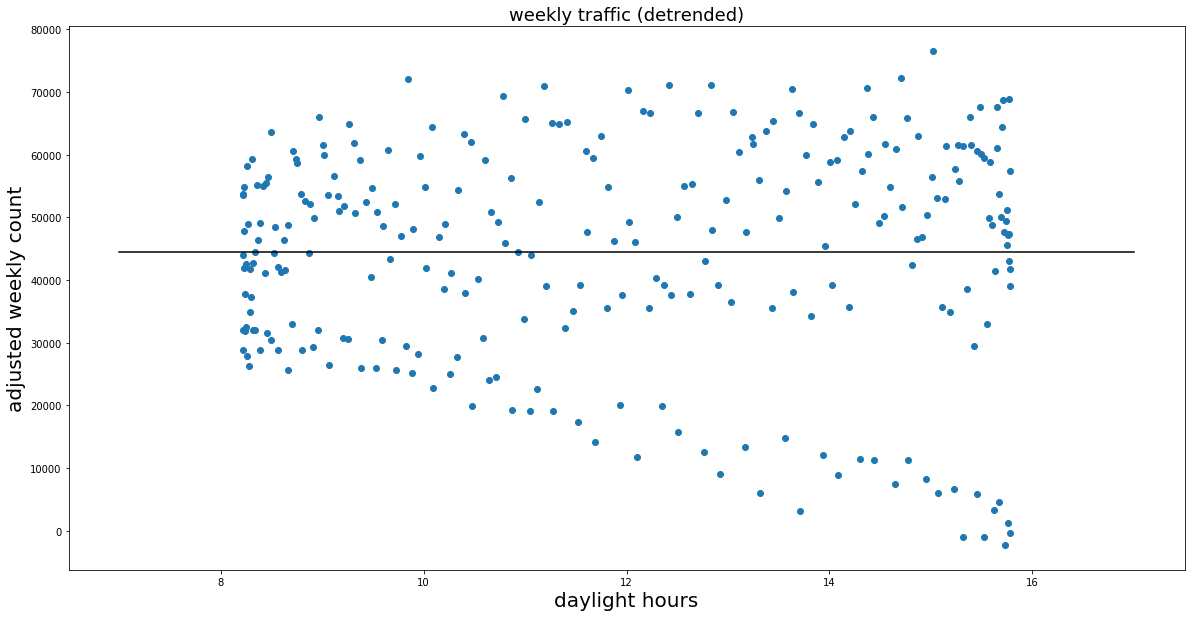

In [184]:
#found trend; subtract trend and replace with mean to "detrend" the data
trend = clf.predict(weekly[['daylight']].as_matrix())
plt.figure(figsize = (defaultfiguresize))
plt.scatter(weekly['daylight'], weekly['TotalCount'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)",size = 18)
plt.xlabel('daylight hours',size = 20)
plt.ylabel('adjusted weekly count',size = 20);

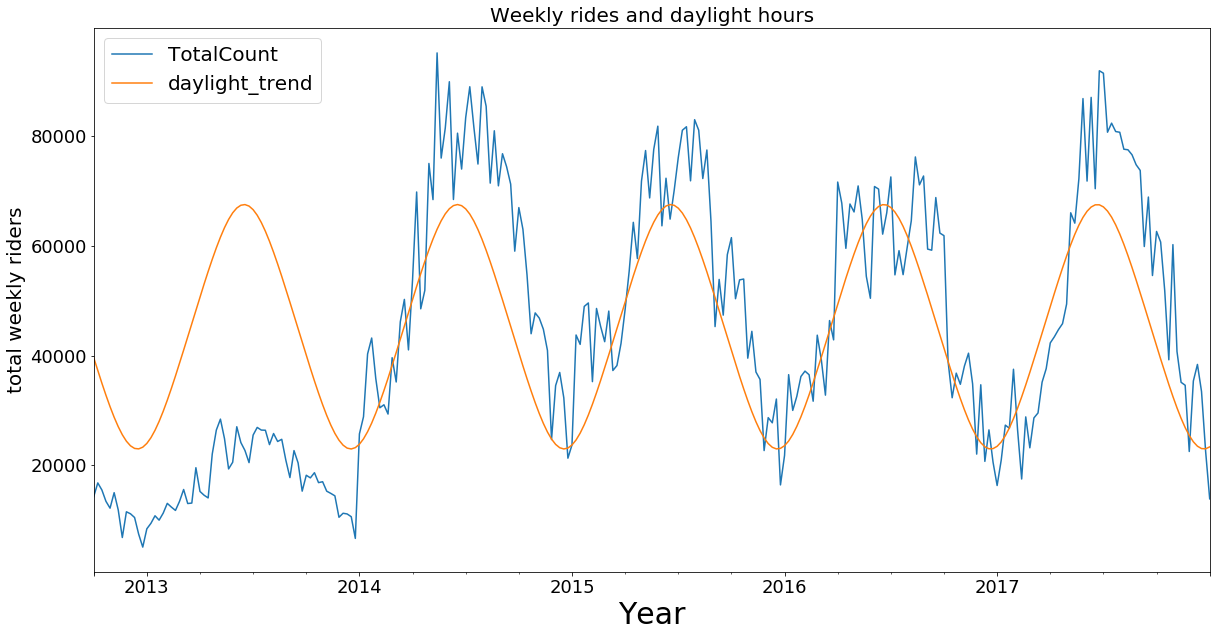

In [193]:
#plot it!
weekly[['TotalCount', 'daylight_trend']].plot(figsize = defaultfiguresize,fontsize=18)
plt.xlabel('Year', size = 30)
plt.ylabel("total weekly riders", size = 20)
plt.legend(loc=2, prop={'size': 20})
plt.title('Weekly rides and daylight hours', size = 20);

root-mean-square about trend: 17642 riders


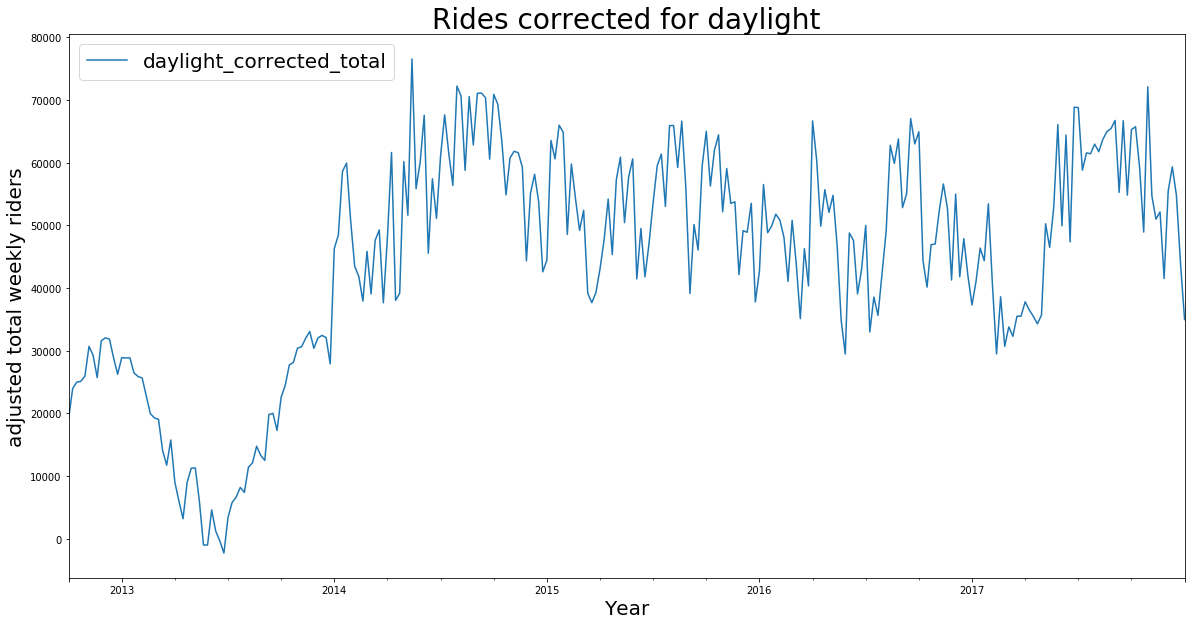

In [197]:
# view adjusted total number of riders counted over time. Thrown off by sampling:
weekly['daylight_corrected_total'].plot(figsize = (defaultfiguresize))
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders", size = 20)
plt.xlabel('Year', size = 20)
plt.legend(loc=2, prop={'size': 20})
plt.title('Rides corrected for daylight', size = 28);
print("root-mean-square about trend: {0:.0f} riders".format(rms))
#note that it's not a clear increase after peak in 2014...

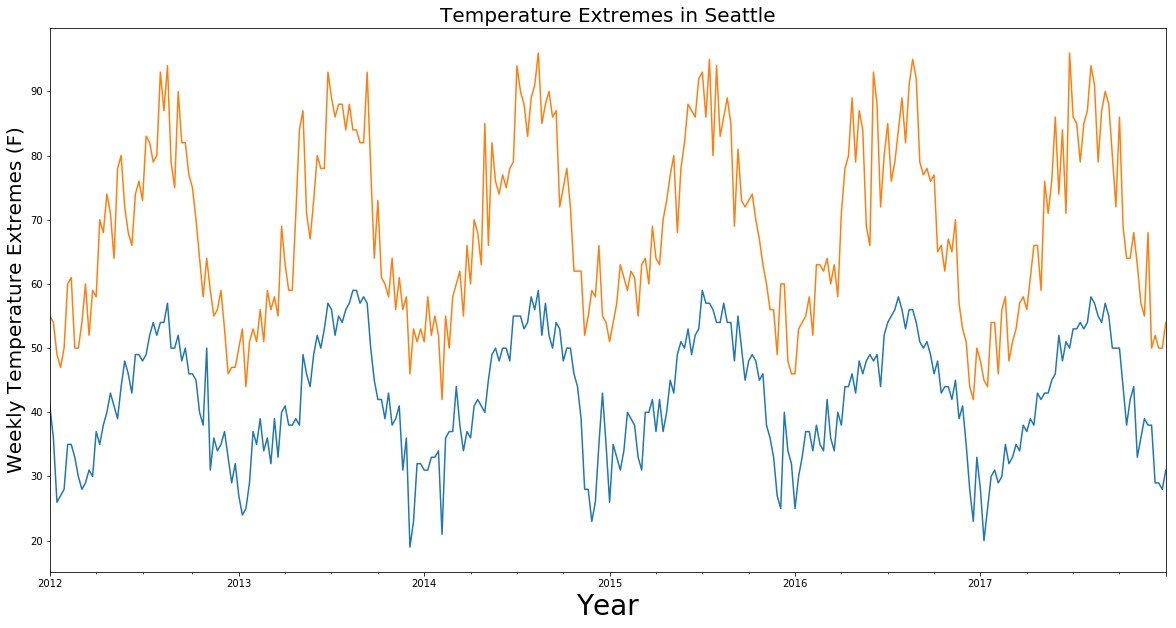

In [201]:
# read NOAA file
weather = pd.read_csv('NOAAweatherDataSeattle2012-2017.csv', index_col='DATE', parse_dates=True, usecols=["DATE","TMAX","TMIN","PRCP"])

weather['TMIN'].resample('w').min().plot(figsize = (defaultfiguresize))
weather['TMAX'].resample('w').max().plot(figsize = (defaultfiguresize))
plt.ylabel('Weekly Temperature Extremes (F)',size=20)
plt.title("Temperature Extremes in Seattle",size=20)
plt.xlabel('Year',size=28);

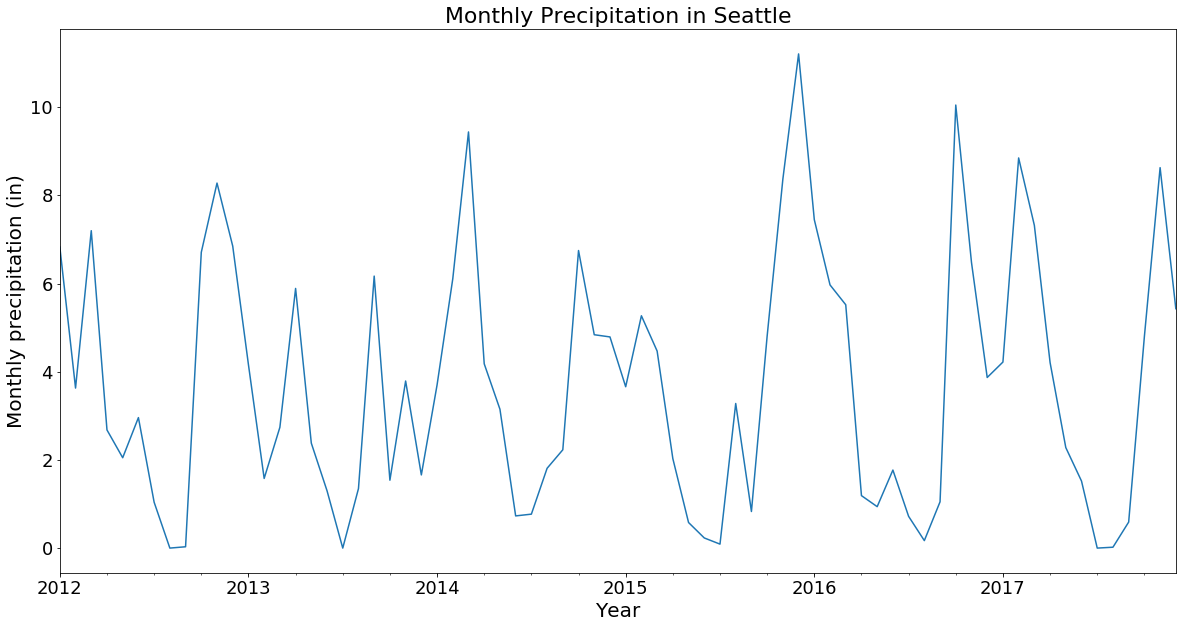

In [207]:
#resample for monthly; a lot of data
weather['PRCP'].resample('m').sum().plot(figsize = (defaultfiguresize),fontsize=18);
plt.ylabel('Monthly precipitation (in)',size=20)
plt.title("Monthly Precipitation in Seattle",size=22)
plt.xlabel('Year',size=20);


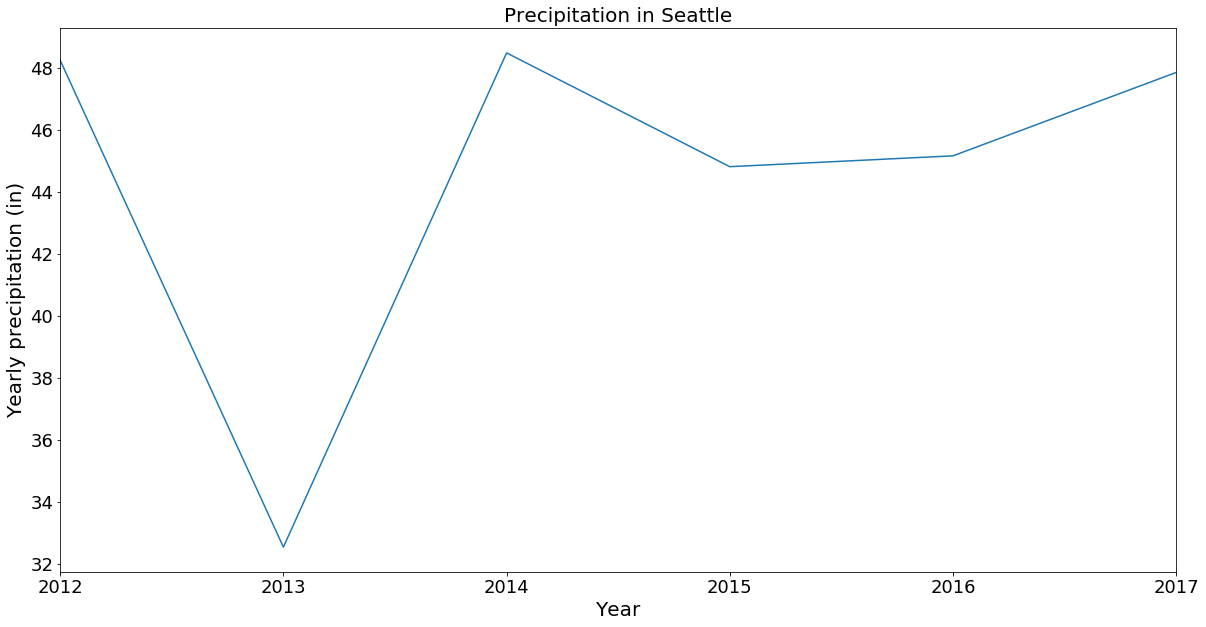

In [210]:
#Seattle averages 37.49 inches of precipitation a year.
weather['PRCP'].resample('a').sum().plot(figsize = (defaultfiguresize),fontsize=18); #end of year sampling...
plt.ylabel('Precipitation (in)',size=20)
plt.title("Yearly precipitation in Seattle",size=20)
plt.xlabel('Year',size=20);
#we've been WAY over that average.

In [211]:
# join the weather data to our daily data
daily = daily.join(weather)

## Show trendline of weather factors

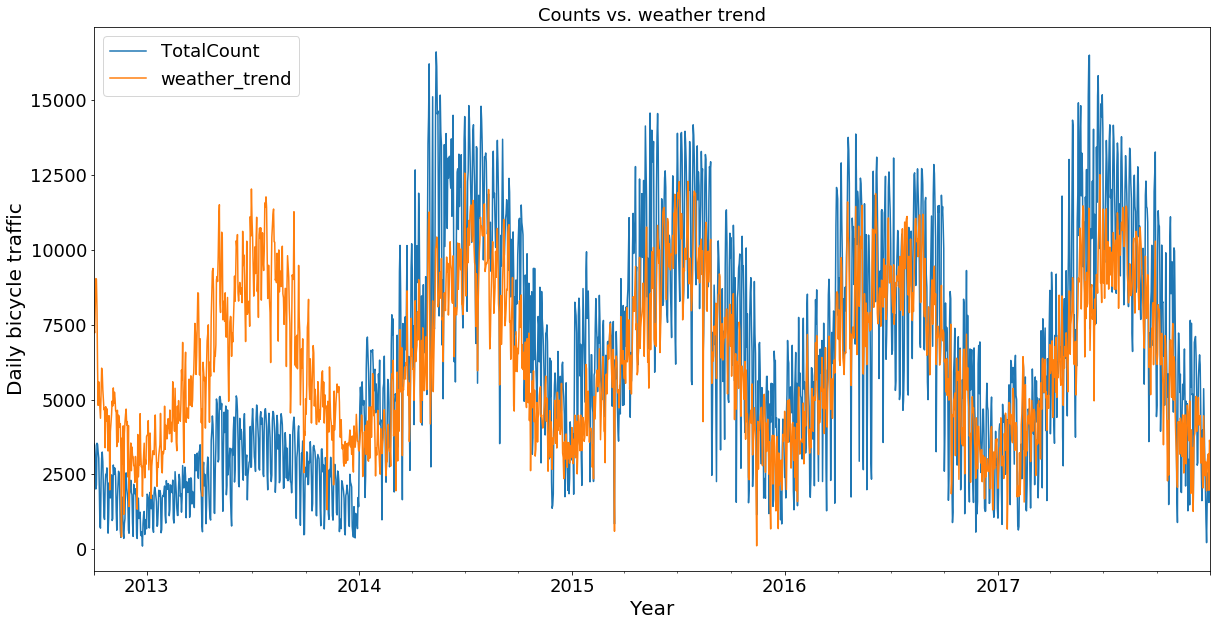

In [217]:
columns = ['TMIN','TMAX', 'PRCP','daylight']

X = daily[columns]
y = daily['TotalCount']
clf = LinearRegression().fit(X, y)
daily['weather_trend'] = clf.predict(X)

# Plot the overall trend
daily[['TotalCount', 'weather_trend']].plot(figsize = (defaultfiguresize),fontsize=18)
plt.ylabel('Daily bicycle traffic',size=20)
plt.xlabel('Year',size=20)
plt.legend(loc=2, prop={'size': 18})
plt.title('Counts vs. weather trend',size = 18);

## What happens if we replace trend with mean values?

rms = 2787


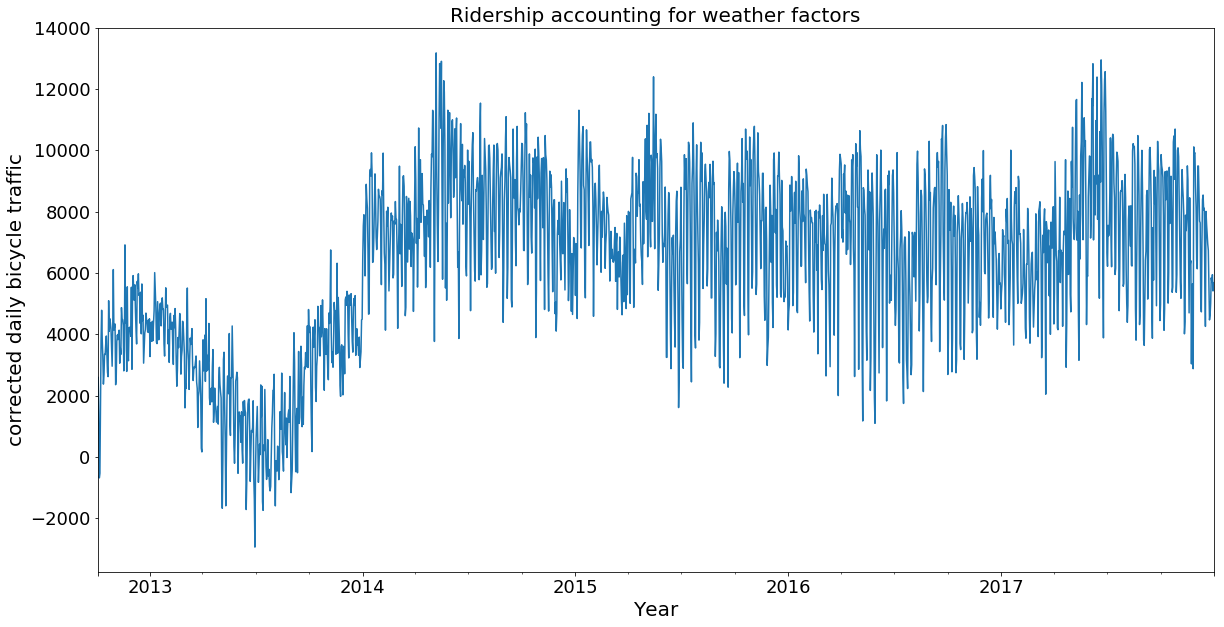

In [220]:
#"de-trend" the data; shows relatively flat when accounting for weather and sunlight

daily['weather_corrected'] = daily['TotalCount'] - daily['weather_trend'] + daily['weather_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['weather_corrected'])))
daily['weather_corrected'].plot(figsize = (defaultfiguresize),fontsize=18)
plt.ylabel('corrected daily bicycle traffic',size=20)
plt.xlabel('Year',size=20)
plt.title('Ridership accounting for weather factors',size=20);
#rms/stdev of 2787 riders means there's a lot of fluctuation not accounted for here.
#also may have introduced a lot of noise because...explain and show slides